In [1]:
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive

ModuleNotFoundError: No module named 'google.colab'

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# from sklearn.metrics import mean_squared_error


In [2]:
###  This is a hack to allow sibling import
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)
from matrix_completion.mat_fact import MatrixFactorization, MF
from matrix_completion.utilis import test_train_split, is_split_good


In [3]:
grp_df = pd.read_csv("../data/input/grouped_data.csv")
grp_df.drop(labels=grp_df.columns[0], axis=1, inplace=True)
grp_df.head()

,INBRED,TESTER,mean
0,Inbred_1071,Tester_1345,0.986544
1,Inbred_1071,Tester_4373,1.057704
2,Inbred_1071,Tester_4473,1.023704
3,Inbred_1071,Tester_4541,1.014735
4,Inbred_1071,Tester_5305,1.062727


In [4]:
train_df = grp_df.pivot(index='INBRED', columns='TESTER', values='mean')
train_df.fillna(0.0, inplace=True)

In [5]:
test_, train_ = test_train_split(train_df=train_df, seed=6)

In [6]:
model = MatrixFactorization(train_df)

In [7]:

kmax = 50
parameters = {
    'alphas': [10**i for i in range(-3,0)],
    'betas': [10**i for i in range(-3,0)],
    'lambdas':[10**i for i in range(-4,0)],
    'ks': list(range(40, kmax+1, 2))
}

bests = model.grid_search(parameters=parameters, kfold=5, iter_max=300, paral=False)


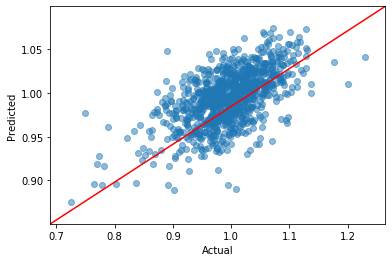

coefficient of determination: 0.35023345004711226
y=0.6839980612948442 + [0.3117251] * x


In [8]:
model.fit()
pred = model.predict(test_)
# plot some results
model.plot_predicted_actual(test_)

#### Lets navigate and grab all 'n' hyperparameters that performed quite well. We need as well the corresponding iteration

In [11]:
res = mf.full_matrix()

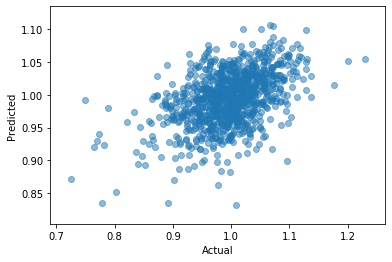

In [12]:
import matplotlib.pyplot as plt
test = test_.values
x = test[test.nonzero()].flatten()
y = res[test.nonzero()].flatten()
plt.scatter(x, y, alpha = 0.5)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

In [8]:
n = 100
top_best = sorted(model.best_param.items(), key=lambda x: np.mean(x[1]['mse']))
topn = top_best[:n]
# for i, obj in enumerate(topn):
#     key, value = obj
#     idx = value['mse'].index(np.min(value['mse']))
#     it = value['iter'][idx]
#     topn[i] = (key, it)

In [10]:
min(pred.min())

0.7881260773180334

In [24]:
np.mean([0.008157180887068073,
   0.007371925827124712,
   0.007110487465182864,
   0.007701334093159228,
   0.007866463353580006])

0.007641478325222976

In [9]:
prediction = None
for param in topn:
    list_mse = param[1]['mse']
    mats = param[1]['best_var']
    ind_min = list_mse.index(np.min(list_mse))
    mat_dict = mats[ind_min]
    b = mat_dict['b']
    b_u = mat_dict['bu']
    b_i = mat_dict['bi']
    P = mat_dict['P']
    Q = mat_dict['Q']
    pred = b + b_u[:,np.newaxis] + b_i[np.newaxis:,] + P.dot(Q.T)
    if prediction is None:
        prediction = pred.copy()
    else:
        prediction = prediction + pred
        
pred_matrix = prediction / len(topn)

In [11]:
np.max(pred_matrix)

1.1253991939899384

In [17]:
test_df = pd.read_csv('../data/input/CC2020_test_final.csv')
test_df.head()

,INBRED,INBRED_CLUSTER,TESTER,TESTER_CLUSTER,YIELD
0,Inbred_1071,Cluster8,Tester_5450,Cluster5,NaN
1,Inbred_122,Cluster12,Tester_4336,Cluster6,NaN
2,Inbred_1337,Cluster17,Tester_2652,Cluster1,NaN
3,Inbred_1337,Cluster17,Tester_4373,Cluster3,NaN
4,Inbred_1339,Cluster17,Tester_4238,Cluster11,NaN


In [19]:
rows = train_df.index
col = train_df.columns
full_df = pd.DataFrame(data=pred_matrix, index=rows, columns=col)


In [20]:
for i in test_df.index:
    inbred = test_df.loc[i, 'INBRED']
    tester = test_df.loc[i, 'TESTER']
    # get the value from the full matrix
    val = full_df.loc[inbred, tester]
    test_df.loc[i, 'YIELD'] = val

In [21]:
test_df.to_csv(filename='../data/output/prediction_submission.csv')

,INBRED,INBRED_CLUSTER,TESTER,TESTER_CLUSTER,YIELD
0,Inbred_1071,Cluster8,Tester_5450,Cluster5,1.062165
1,Inbred_122,Cluster12,Tester_4336,Cluster6,1.027149
2,Inbred_1337,Cluster17,Tester_2652,Cluster1,0.934081
3,Inbred_1337,Cluster17,Tester_4373,Cluster3,0.967856
4,Inbred_1339,Cluster17,Tester_4238,Cluster11,0.971580
5,Inbred_1339,Cluster17,Tester_4250,Cluster11,0.985152
6,Inbred_1339,Cluster17,Tester_4270,Cluster5,0.965069
7,Inbred_1339,Cluster17,Tester_5311,Cluster1,0.980721
8,Inbred_1339,Cluster17,Tester_7050,Cluster3,0.988586
9,Inbred_1339,Cluster17,Tester_7115,Cluster3,0.991703


In [11]:
# def correction(y):
#     return (y - 0.23596519750208478) / 0.7634398

In [13]:
pred_matrix

array([[1.02537191, 1.02454247, 1.02882919, ..., 0.96689598, 1.03359132,
        0.97946585],
       [1.03036412, 1.02950482, 1.03318299, ..., 0.97208455, 1.03834655,
        0.98381846],
       [0.96439442, 0.96417411, 0.96740644, ..., 0.9064579 , 0.97237568,
        0.91831574],
       ...,
       [1.02098028, 1.02001141, 1.02412708, ..., 0.9629    , 1.02857207,
        0.97379616],
       [1.00652532, 1.00551805, 1.00975451, ..., 0.94758416, 1.01380725,
        0.95914737],
       [1.01343403, 1.01304668, 1.01645326, ..., 0.95527812, 1.02160318,
        0.96690588]])

In [15]:
pred.apply(correction).head()

TESTER,Tester_1345,Tester_1349,Tester_1397,Tester_2636,Tester_2652,Tester_2683,Tester_2689,Tester_2690,Tester_2721,Tester_2724,...,Tester_821,Tester_8218,Tester_8246,Tester_8248,Tester_8249,Tester_8250,Tester_8253,Tester_8254,Tester_828,Tester_829
INBRED,,,,,,,,,,,,,,,,,,,,,
Inbred_1071,0.960248,1.072859,0.853497,0.954354,0.981084,0.951334,0.905989,1.002726,0.732800,0.906590,...,1.069394,1.130785,0.876549,1.040942,1.131783,1.305137,0.982661,0.846477,1.020654,1.040759
Inbred_122,0.991007,1.277923,0.968752,1.172546,1.148055,1.013730,0.858975,0.943870,1.202416,0.513578,...,1.181079,1.077675,0.867327,1.184029,0.888835,1.253450,1.181471,0.570893,1.093515,0.967627
Inbred_1337,1.116238,1.076004,1.070392,0.816487,1.198018,0.500668,0.986212,1.163561,0.603596,1.150713,...,1.131569,0.763190,0.833753,0.964613,1.133970,1.275041,0.823543,1.115956,0.934752,0.778390
Inbred_1339,0.998943,1.083697,1.059308,0.789831,1.239354,0.210427,0.764500,0.957091,0.834656,0.633761,...,1.064582,0.383970,0.608767,0.882642,0.687332,1.011313,0.770064,0.726572,0.778381,0.414438
Inbred_1340,0.994563,1.034544,0.676873,1.079141,0.723833,1.726039,1.160108,1.170362,0.454562,1.486461,...,1.099733,1.977327,1.231918,1.202647,1.792767,1.710140,1.165308,1.210375,1.304240,1.781526


In [10]:
test_.index

Index(['Inbred_1071', 'Inbred_122', 'Inbred_1337', 'Inbred_1339',
       'Inbred_1340', 'Inbred_1341', 'Inbred_1342', 'Inbred_1344',
       'Inbred_1345', 'Inbred_1346',
       ...
       'Inbred_801', 'Inbred_803', 'Inbred_804', 'Inbred_805', 'Inbred_810',
       'Inbred_818', 'Inbred_819', 'Inbred_821', 'Inbred_828', 'Inbred_836'],
      dtype='object', name='INBRED', length=593)

In [ ]:
kmax = 30
ks  = range(2, kmax+1, 2)
alphas = [10**i for i in range(-5,0)]
betas = [10**i for i in range(-5,0)]
lambdas = [10**i for i in range(-5,0)]
best_test_error = {}
for k in ks:
    print(f'running k = {k}')
    if k > 5:
        for a in alphas:
            for beta in betas:
                for lambda_bias in lambdas:
                    
                    mf = MF(train_df.values, K=k, alpha=a, beta=beta, iterations=300, lambda_bias=lambda_bias, test=test_df.values)
                    training_process, test_process = mf.train()
                    best_test_error[(k, a, beta, lambda_bias)] = min(test_process)

In [ ]:
mf = MF(train_.values, 26, 0.001, 0.001, 150, 1e-05, test=test_.values)
training_process, test_process = mf.train()

In [ ]:
assert(np.all((train_df.values * test_df.values) == 0))

In [ ]:
fig, axs = plt.subplots(1, 2)
axs[0].plot(test_process)
axs[0].set_title('Test error')
axs[1].plot(list(map(lambda x: x[1], training_process)))
axs[1].set_title('Training  error')

In [2]:
def abline():
    gca = plt.gca()
    gca.set_autoscale_on(False)
    gca.plot(gca.get_xlim(),gca.get_ylim(), 'red')
    
test = test_.values
x = test[test.nonzero()].flatten()
y = mf.full_matrix()[test.nonzero()].flatten()
plt.scatter(x, y, alpha = 0.5)
plt.xlabel("actual test")
plt.ylabel("predicted test")
abline()
plt.show()

NameError: name 'test_' is not defined

In [ ]:
to_write = open('split1.txt', 'a')
to_write.write("a\\n")
to_write.close()

In [ ]:
# mf = MF(train_df.values, K=10, alpha=0.01, beta=0.1, iterations=300, lambda_bias=0.15, test=test_df.values)
# training_process, test_process = mf.train()

In [ ]:
plt.hist(mf.full_matrix().flatten())

In [ ]:
best_test_error

In [ ]:
ordered_results = sorted(best_test_error.items(), key=lambda x: x[1])

In [ ]:
ordered_results

In [ ]:
best_test_error.itertuple()

In [ ]:
max(best_test_error.values())

In [ ]:
# elements = [val for i, val in enumerate(ordered_results) if i < 20]
count = 0
with open('results.txt', 'w') as f:
    while count < 20:
        val = ordered_results[count]
        f.write(str(val)[1:-1] + '\n')
        count +=1


In [ ]:
k, a, beta, lambda_bias = 26, 0.001, 0.001, 1e-05
mf = MF(train_df.values, K=k, alpha=a, beta=beta, iterations=300, lambda_bias=lambda_bias, test=test_df.values)
training_process, test_process = mf.train()
plt.plot(test_process)

In [ ]:
plt.plot(test_process)

In [ ]:
print(min(test_process))

In [ ]:
# another MF method

In [ ]:
class ExplicitMF():
    def __init__(self, 
                 ratings,
                 n_factors=40,
                 learning='sgd',
                 item_fact_reg=0.1, 
                 user_fact_reg=0.1,
                 item_bias_reg=0.1,
                 user_bias_reg=0.1,
                 verbose=False):
        """
        Train a matrix factorization model to predict empty 
        entries in a matrix. The terminology assumes a 
        ratings matrix which is ~ user x item
        
        Params
        ======
        ratings : (ndarray)
            User x Item matrix with corresponding ratings
        
        n_factors : (int)
            Number of latent factors to use in matrix 
            factorization model
        learning : (str)
            Method of optimization. Options include 
            'sgd' or 'als'.
        
        item_fact_reg : (float)
            Regularization term for item latent factors
        
        user_fact_reg : (float)
            Regularization term for user latent factors
            
        item_bias_reg : (float)
            Regularization term for item biases
        
        user_bias_reg : (float)
            Regularization term for user biases
        
        verbose : (bool)
            Whether or not to printout training progress
        """
        
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.item_fact_reg = item_fact_reg
        self.user_fact_reg = user_fact_reg
        self.item_bias_reg = item_bias_reg
        self.user_bias_reg = user_bias_reg
        self.learning = learning
        if self.learning == 'sgd':
            self.sample_row, self.sample_col = self.ratings.nonzero()
            self.n_samples = len(self.sample_row)
        self._v = verbose

    def als_step(self,
                 latent_vectors,
                 fixed_vecs,
                 ratings,
                 _lambda,
                 type='user'):
        """
        One of the two ALS steps. Solve for the latent vectors
        specified by type.
        """
        if type == 'user':
            # Precompute
            YTY = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(YTY.shape[0]) * _lambda

            for u in range(latent_vectors.shape[0]):
                latent_vectors[u, :] = solve((YTY + lambdaI), 
                                             ratings[u, :].dot(fixed_vecs))
        elif type == 'item':
            # Precompute
            XTX = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(XTX.shape[0]) * _lambda
            
            for i in range(latent_vectors.shape[0]):
                latent_vectors[i, :] = solve((XTX + lambdaI), 
                                             ratings[:, i].T.dot(fixed_vecs))
        return latent_vectors

    def train(self, n_iter=10, learning_rate=0.01):
        """ Train model for n_iter iterations from scratch."""
        # initialize latent vectors        
        self.user_vecs = np.random.normal(scale=1./self.n_factors,\
                                          size=(self.n_users, self.n_factors))
        self.item_vecs = np.random.normal(scale=1./self.n_factors,
                                          size=(self.n_items, self.n_factors))
        self.user_vecs_velocity = np.zeros((self.n_users, self.n_factors))
        self.item_vecs_velocity = np.zeros((self.n_items, self.n_factors))

        if self.learning == 'als':
            self.partial_train(n_iter)
        elif self.learning == 'sgd':
            self.learning_rate = learning_rate
            self.momentum = 0.9
            self.user_bias = np.zeros(self.n_users)
            self.item_bias = np.zeros(self.n_items)
            self.user_bias_velocity = np.zeros(self.n_users)
            self.item_bias_velocity = np.zeros(self.n_items)
            self.global_bias = np.mean(self.ratings[np.where(self.ratings != 0)])
            self.partial_train(n_iter)
    
    
    def partial_train(self, n_iter):
        """ 
        Train model for n_iter iterations. Can be 
        called multiple times for further training.
        """
        ctr = 1
        while ctr <= n_iter:
            if ctr % 10 == 0 and self._v:
                print ('\tcurrent iteration: {}'.format(ctr))
            if self.learning == 'als':
                self.user_vecs = self.als_step(self.user_vecs, 
                                               self.item_vecs, 
                                               self.ratings, 
                                               self.user_fact_reg, 
                                               type='user')
                self.item_vecs = self.als_step(self.item_vecs, 
                                               self.user_vecs, 
                                               self.ratings, 
                                               self.item_fact_reg, 
                                               type='item')
            elif self.learning == 'sgd':
                self.training_indices = np.arange(self.n_samples)
                np.random.shuffle(self.training_indices)
                self.sgd()
            ctr += 1

    def sgd(self):
        for idx in self.training_indices:
            u = self.sample_row[idx]
            i = self.sample_col[idx]
            prediction = self.predict(u, i)
            e = (self.ratings[u,i] - prediction) # error
            
            # Update biases
            self.user_bias_velocity[u] = self.momentum * self.user_bias_velocity[u] + \
                                        self.learning_rate * (e - self.user_bias_reg * self.user_bias[u])
            self.user_bias[u] += self.user_bias_velocity[u]

            self.item_bias_velocity[i] = self.momentum * self.item_bias_velocity[i] + \
                                        self.learning_rate * (e - self.item_bias_reg * self.item_bias[i])
            self.item_bias[i] += self.item_bias_velocity[i]

            # self.user_bias[u] += self.learning_rate * \
            #                     (e - self.user_bias_reg * self.user_bias[u])
            # self.item_bias[i] += self.learning_rate * \
            #                     (e - self.item_bias_reg * self.item_bias[i])
            
            #Update latent factors
            self.user_vecs_velocity[u, :] = self.momentum * self.user_vecs_velocity[u, :] + \
                                        self.learning_rate * \
                                        (e * self.item_vecs[i, :] - \
                                        self.user_fact_reg * self.user_vecs[u,:])
            self.user_vecs[u, :] += self.user_vecs_velocity[u, :]

            self.item_vecs_velocity[i, :] = self.momentum * self.item_vecs_velocity[i, :] + \
                                        self.learning_rate * \
                                        (e * self.user_vecs[u, :] - \
                                        self.item_fact_reg * self.item_vecs[i,:])
            self.item_vecs[i :] += self.item_vecs_velocity[i, :]

            # self.user_vecs[u, :] += self.learning_rate * \
            #                         (e * self.item_vecs[i, :] - \
            #                          self.user_fact_reg * self.user_vecs[u,:])
            # self.item_vecs[i, :] += self.learning_rate * \
            #                         (e * self.user_vecs[u, :] - \
            #                          self.item_fact_reg * self.item_vecs[i,:])
    def predict(self, u, i):
        """ Single user and item prediction."""
        if self.learning == 'als':
            return self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
        elif self.learning == 'sgd':
            prediction = self.global_bias + self.user_bias[u] + self.item_bias[i]
            prediction += self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
            return prediction
    
    def predict_all(self):
        """ Predict ratings for every user and item."""
        predictions = np.zeros((self.user_vecs.shape[0], 
                                self.item_vecs.shape[0]))
        for u in range(self.user_vecs.shape[0]):
            for i in range(self.item_vecs.shape[0]):
                predictions[u, i] = self.predict(u, i)
                
        return predictions
    
    def calculate_learning_curve(self, iter_array, test, learning_rate=0.01):
        """
        Keep track of MSE as a function of training iterations.
        
        Params
        ======
        iter_array : (list)
            List of numbers of iterations to train for each step of 
            the learning curve. e.g. [1, 5, 10, 20]
        test : (2D ndarray)
            Testing dataset (assumed to be user x item).
        
        The function creates two new class attributes:
        
        train_mse : (list)
            Training data MSE values for each value of iter_array
        test_mse : (list)
            Test data MSE values for each value of iter_array
        """
        iter_array.sort()
        self.train_mse =[]
        self.test_mse = []
        iter_diff = 0
        for (i, n_iter) in enumerate(iter_array):
            if self._v:
                print ('Iteration: {}'.format(n_iter))
            if i == 0:
                self.train(n_iter - iter_diff, learning_rate)
            else:
                self.partial_train(n_iter - iter_diff)

            predictions = self.predict_all()

            self.train_mse += [get_mse(predictions, self.ratings)]
            self.test_mse += [get_mse(predictions, test)]
            if self._v:
                print ('Train mse: ' + str(self.train_mse[-1]))
                print ('Test mse: ' + str(self.test_mse[-1]))
            iter_diff = n_iter

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def plot_learning_curve(iter_array, model):
    plt.plot(iter_array, model.train_mse, \
             label='Training', linewidth=5)
    plt.plot(iter_array, model.test_mse, \
             label='Test', linewidth=5)


    plt.xticks(fontsize=16);
    plt.yticks(fontsize=16);
    plt.xlabel('iterations', fontsize=30);
    plt.ylabel('MSE', fontsize=30);
    plt.legend(loc='best', fontsize=20);

In [ ]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [ ]:
#MF_SGD = ExplicitMF(train, 40, learning='sgd', verbose=True)
MF_SGD = ExplicitMF(train_df.values,
                    n_factors=40,
                    learning='sgd',
                    
                    item_fact_reg=0.1, 
                    user_fact_reg=0.1,
                    item_bias_reg=0.1,
                    user_bias_reg=0.1,
                    verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100, 200,300]
MF_SGD.calculate_learning_curve(iter_array, test_df.values, learning_rate=0.001)

In [ ]:
plot_learning_curve(iter_array, MF_SGD)

In [ ]:
iter_array

In [ ]:
get_mse(MF_SGD.predict_all(),test_df.values)

In [ ]:
get_mse(mf.full_matrix(),test_df.values)

In [ ]:
# try to take log, train, then exponentiate back
train_df_log = np.ma.log(train_df.values)
train_df_log = train_df_log.filled(0)
test_df_log = np.ma.log(test_df.values)
test_df_log = test_df_log.filled(0)

In [ ]:
k, a, beta, lambda_bias = 26, 0.001, 0.001, 1e-05
mf = MF(train_df_log, K=k, alpha=a, beta=beta, iterations=300, lambda_bias=lambda_bias, test=test_df_log)
training_process, test_process = mf.train()
plt.plot(test_process)

In [ ]:
get_mse(np.exp(mf.full_matrix()),test_df.values)

In [ ]:
MF_SGD = ExplicitMF(train_df.values,
                    n_factors=40,
                    learning='sgd',
                    item_fact_reg=0.1, 
                    user_fact_reg=0.1,
                    item_bias_reg=0.1,
                    user_bias_reg=0.1,
                    verbose=False)
iter_array = [1, 2, 5, 10, 25, 50]
MF_SGD.calculate_learning_curve(iter_array, test_df.values, learning_rate=0.001)

In [ ]:
MF_SGD = ExplicitMF(train,
                    n_factors=40,
                    learning='sgd',
                    item_fact_reg=0.1, 
                    user_fact_reg=0.1,
                    item_bias_reg=0.1,
                    user_bias_reg=0.1,
                    verbose=True)
iter_array = [1, 2, 5, 10, 25, 50]
MF_SGD.calculate_learning_curve(iter_array, test, learning_rate=0.001)

In [ ]:
get_mse(np.exp(MF_SGD.predict_all()),np.exp(test))

In [ ]:
plot_learning_curve(iter_array, MF_SGD)

In [ ]:
from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, BiScaler

In [ ]:
X_incomplete = train_df.replace(0,np.nan)

In [ ]:
X_incomplete_log = np.log(X_incomplete)

In [ ]:
X_filled_nnm = NuclearNormMinimization().fit_transform(X_incomplete.values)

In [3]:
null_mat = X_incomplete_log.isnull().values

NameError: name 'X_incomplete_log' is not defined

In [ ]:
null_mat[0,:].sum()

In [ ]:
null_mat.shape

In [ ]:
X_incomplete = train_df.copy()

In [ ]:
for i in range(len(null_mat)):
    #print(train_df_log[i,0])
    if null_mat[i,:].sum() == 496:
        print("zero row")
        idx = np.random.choice(495)
        X_incomplete.iloc[i,idx] = 0.01

In [ ]:
X_incomplete.replace(0, np.nan, inplace= True)

In [ ]:
X_incomplete_log

In [ ]:
si = SoftImpute(max_iters = 1000)


In [ ]:
# X_incomplete_normalized = BiScaler().fit_transform(train_na)
X_filled_softimpute = si.fit_transform(train_na)

In [ ]:
get_mse(np.exp(X_filled_softimpute), np.exp(test))

In [ ]:
plt.scatter(np.exp(test[test.nonzero()]).flatten(), np.exp(X_filled_softimpute[test.nonzero()].flatten()), alpha = 0.5)
#plt.plot(np.exp(test[test.nonzero()]).flatten(), alpha = 0.5)
plt.xlabel("test")
plt.ylabel("pred test")
plt.show()

In [ ]:
np.sqrt(0.00017838840904557725)

In [ ]:
np.exp(train).max()

In [ ]:
np.exp(X_filled_softimpute).min()

In [ ]:
np.exp(X_filled_softimpute).max()

In [ ]:
get_mse(MF_SGD.predict_all(),test_df.values)

In [ ]:
get_mse(np.exp(MF_SGD.predict_all()),test_df.values)

In [ ]:
res = np.exp(MF_SGD.predict_all())

In [ ]:
res.min()

In [ ]:
res.max()

In [ ]:
train_df.values.max()

In [ ]:
res.nonzero()

In [ ]:
np.exp(MF_SGD.predict_all())
plt.hist(np.exp(MF_SGD.predict_all())[test.nonzero()].flatten(), alpha = 0.5, label = "test prediction",bins = 20)
plt.title("Histogram of Test Prediction vs Test Data")
plt.hist(np.exp(test)[test.nonzero()].flatten(), alpha = 0.5, label = "test data",bins = 20)
plt.legend(loc = "best")
plt.show()

In [ ]:
plt.hist(np.exp(MF_SGD.predict_all())[train.nonzero()].flatten(), alpha = 0.5, label = "train prediction")
plt.title("Histogram of Train Prediction vs Train Data")
plt.hist(np.exp(train)[train.nonzero()].flatten(), alpha = 0.5, label = "train data")
plt.legend(loc = "best")
plt.show()

In [ ]:
plt.hist(np.exp(X_filled_softimpute)[test.nonzero()].flatten(), alpha = 0.5, label = "test prediction")
plt.title("Histogram of Test Prediction vs Test Data")
plt.hist(np.exp(test)[test.nonzero()].flatten(), alpha = 0.5, label = "test data")
plt.legend(loc = "best")
plt.show()

In [ ]:
plt.hist(np.exp(X_filled_softimpute)[train.nonzero()].flatten(), alpha = 0.5, label = "train prediction")
plt.title("Histogram of Train Prediction vs Train Data")
plt.hist(np.exp(train)[train.nonzero()].flatten(), alpha = 0.5, label = "train data")
plt.legend(loc = "best")
plt.show()

In [ ]:
np.exp(X_filled_softimpute)[test.nonzero()].flatten().min()

In [ ]:
np.exp(test)[test.nonzero()].flatten().min()

In [ ]:
test

In [ ]:
np.all(train*test) == 0

In [ ]:
plt.hist(np.exp(X_filled_softimpute)[test.nonzero()].flatten())

In [ ]:
plt.hist(test_df.values[test_df.values.nonzero()].flatten())

In [ ]:
plt.hist(res[train_df.values.nonzero()].flatten())

In [ ]:
plt.hist(train_df.values[train_df.values.nonzero()].flatten())

In [ ]:
train_df.values.nonzero()[0]

In [ ]:
iter_array = [1, 2, 5, 10, 25, 50, 100, 200,250]
learning_rates = [1e-5, 1e-4, 1e-3, 1e-2]

best_params = {}
best_params['learning_rate'] = None
best_params['n_iter'] = 0
best_params['train_mse'] = np.inf
best_params['test_mse'] = np.inf
best_params['model'] = None


for rate in learning_rates:
    print ('Rate: {}'.format(rate))
    MF_SGD = ExplicitMF(train_df_log, n_factors=35, learning='sgd')
    MF_SGD.calculate_learning_curve(iter_array, test_df_log, learning_rate=rate)
    min_idx = np.argmin(MF_SGD.test_mse)
    if MF_SGD.test_mse[min_idx] < best_params['test_mse']:
        best_params['n_iter'] = iter_array[min_idx]
        best_params['learning_rate'] = rate
        best_params['train_mse'] = MF_SGD.train_mse[min_idx]
        best_params['test_mse'] = MF_SGD.test_mse[min_idx]
        best_params['model'] = MF_SGD
        print ('New optimal hyperparameters')
        print (pd.Series(best_params))

In [ ]:
best_params #for learning rate

In [ ]:
iter_array = [1, 2, 5, 10, 25, 50, 100, 200, 250]
latent_factors = [ 5, 10, 20, 25, 30, 35, 40]
regularizations = [0.001, 0.01, 0.1, 1.]
regularizations.sort()

best_params = {}
best_params['n_factors'] = latent_factors[0]
best_params['reg'] = regularizations[0]
best_params['n_iter'] = 0
best_params['train_mse'] = np.inf
best_params['test_mse'] = np.inf
best_params['model'] = None

for fact in latent_factors:
    print ('Factors: {}'.format(fact))
    for reg in regularizations:
        print ('Regularization: {}'.format(reg))
        MF_SGD = ExplicitMF(train_df_log, n_factors=fact, learning='sgd',\
                            user_fact_reg=reg, item_fact_reg=reg, \
                            user_bias_reg=reg, item_bias_reg=reg)
        MF_SGD.calculate_learning_curve(iter_array, test_df_log, learning_rate=0.001)
        min_idx = np.argmin(MF_SGD.test_mse)
        if MF_SGD.test_mse[min_idx] < best_params['test_mse']:
            best_params['n_factors'] = fact
            best_params['reg'] = reg
            best_params['n_iter'] = iter_array[min_idx]
            best_params['train_mse'] = MF_SGD.train_mse[min_idx]
            best_params['test_mse'] = MF_SGD.test_mse[min_idx]
            best_params['model'] = MF_SGD
            print ('New optimal hyperparameters')
            print (pd.Series(best_params))

In [ ]:
best_params #for factors and reg

In [4]:
from numpy.linalg import solve

class ExplicitMF():
    def __init__(self, 
                 ratings, 
                 n_factors=40, 
                 item_reg=0.0, 
                 user_reg=0.0,
                 verbose=False):
        """
        Train a matrix factorization model to predict empty 
        entries in a matrix. The terminology assumes a 
        ratings matrix which is ~ user x item
        
        Params
        ======
        ratings : (ndarray)
            User x Item matrix with corresponding ratings
        
        n_factors : (int)
            Number of latent factors to use in matrix 
            factorization model
        
        item_reg : (float)
            Regularization term for item latent factors
        
        user_reg : (float)
            Regularization term for user latent factors
        
        verbose : (bool)
            Whether or not to printout training progress
        """
        
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.item_reg = item_reg
        self.user_reg = user_reg
        self._v = verbose

    def als_step(self,
                 latent_vectors,
                 fixed_vecs,
                 ratings,
                 _lambda,
                 type='user'):
        """
        One of the two ALS steps. Solve for the latent vectors
        specified by type.
        """
        if type == 'user':
            # Precompute
            YTY = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(YTY.shape[0]) * _lambda

            for u in range(latent_vectors.shape[0]):
                latent_vectors[u, :] = solve((YTY + lambdaI), 
                                             ratings[u, :].dot(fixed_vecs))
        elif type == 'item':
            # Precompute
            XTX = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(XTX.shape[0]) * _lambda
            
            for i in range(latent_vectors.shape[0]):
                latent_vectors[i, :] = solve((XTX + lambdaI), 
                                             ratings[:, i].T.dot(fixed_vecs))
        return latent_vectors

    def train(self, n_iter=10):
        """ Train model for n_iter iterations from scratch."""
        # initialize latent vectors
        self.user_vecs = np.random.random((self.n_users, self.n_factors))
        self.item_vecs = np.random.random((self.n_items, self.n_factors))
        
        self.partial_train(n_iter)
    
    def partial_train(self, n_iter):
        """ 
        Train model for n_iter iterations. Can be 
        called multiple times for further training.
        """
        ctr = 1
        while ctr <= n_iter:
            if ctr % 10 == 0 and self._v:
                print ('\tcurrent iteration: {}'.format(ctr))
            self.user_vecs = self.als_step(self.user_vecs, 
                                           self.item_vecs, 
                                           self.ratings, 
                                           self.user_reg, 
                                           type='user')
            self.item_vecs = self.als_step(self.item_vecs, 
                                           self.user_vecs, 
                                           self.ratings, 
                                           self.item_reg, 
                                           type='item')
            ctr += 1
    
    def predict_all(self):
        """ Predict ratings for every user and item. """
        predictions = np.zeros((self.user_vecs.shape[0], 
                                self.item_vecs.shape[0]))
        for u in range(self.user_vecs.shape[0]):
            for i in range(self.item_vecs.shape[0]):
                predictions[u, i] = self.predict(u, i)
                
        return predictions
    def predict(self, u, i):
        """ Single user and item prediction. """
        return self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
    
    def calculate_learning_curve(self, iter_array, test):
        """
        Keep track of MSE as a function of training iterations.
        
        Params
        ======
        iter_array : (list)
            List of numbers of iterations to train for each step of 
            the learning curve. e.g. [1, 5, 10, 20]
        test : (2D ndarray)
            Testing dataset (assumed to be user x item).
        
        The function creates two new class attributes:
        
        train_mse : (list)
            Training data MSE values for each value of iter_array
        test_mse : (list)
            Test data MSE values for each value of iter_array
        """
        iter_array.sort()
        self.train_mse =[]
        self.test_mse = []
        iter_diff = 0
        for (i, n_iter) in enumerate(iter_array):
            if self._v:
                print ('Iteration: {}'.format(n_iter))
            if i == 0:
                self.train(n_iter - iter_diff)
            else:
                self.partial_train(n_iter - iter_diff)

            predictions = self.predict_all()

            self.train_mse += [get_mse(predictions, self.ratings)]
            self.test_mse += [get_mse(predictions, test)]
            if self._v:
                print ('Train mse: ' + str(self.train_mse[-1]))
                print ('Test mse: ' + str(self.test_mse[-1]))
            iter_diff = n_iter

In [5]:
MF_ALS = ExplicitMF(train_df_log, n_factors=30, \
                    user_reg=0.1, item_reg=0.1)

iter_array = [1, 2, 5, 10, 25, 50, 100]
MF_ALS.calculate_learning_curve(iter_array, test_df_log)

NameError: name 'train_df_log' is not defined

In [ ]:
MF_ALS = ExplicitMF(train, n_factors=30, \
                    user_reg=0.1, item_reg=0.1)

iter_array = [1, 2, 5, 10, 25, 50, 100]
MF_ALS.calculate_learning_curve(iter_array, test)

In [ ]:
#mse of ALS method 
als_pred = MF_ALS.predict_all()
als_pred = np.exp(als_pred)
print(als_pred.min())
print(als_pred.max())
print("mse of ALS method: ", get_mse(als_pred, test)) # it is better than SGD method :o 
print((np.exp(train)).max(), (np.exp(train)).min())
print((np.exp(test)).max(), (np.exp(test)).min())

In [ ]:
plot_learning_curve(iter_array, MF_ALS)

In [ ]:
# my code to process the training data to have at least 1 entry in each row or column
train_df = pd.read_csv("../data/input/CC2020_train_final.csv")
# test_df = pd.read_csv("CC2020_test_final.csv")

In [ ]:
a = np.array([0,0,0])
a.nonzero()[0]
np.random.choice(a.nonzero()[0])

In [ ]:
train_df = train_df[['INBRED', 'TESTER', 'YIELD']]
grouped_df = train_df.groupby(['INBRED','TESTER'], as_index=False).mean()
grouped_df['YIELD'] = np.log(grouped_df['YIELD']).values
train_df = grouped_df
def train_test_split(mat):
    test = np.zeros(mat.shape)
    train = mat.copy()
    for inbred in range(mat.shape[0]):
        test_yields = np.random.choice(mat[inbred, :].nonzero()[0], 
                                        size=max(1, len(mat[inbred, :].nonzero()[0])//10), 
                                        replace=False)
        train[inbred, test_yields] = 0.
        test[inbred, test_yields] = mat[inbred, test_yields]
        
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test
inbred_index = {}
tester_index = {}
i = 0
j = 0
for idx, row in train_df.iterrows():
    if row['INBRED'] not in inbred_index:
        inbred_index[row['INBRED']] = i
        i += 1
    if row['TESTER'] not in tester_index:
        tester_index[row['TESTER']] = j
        j += 1
print(len(inbred_index))
print(len(tester_index))
print(i)
print(j)
n_inbred = 593
n_tester = 496
mat = np.zeros((n_inbred, n_tester))
for row in train_df.itertuples():
    mat[inbred_index[row[1]], tester_index[row[2]]] = row[3]
mat



In [ ]:
def train_test_split(mat):
    test = np.zeros(mat.shape)
    train = mat.copy()
    for inbred in range(mat.shape[0]):
        if (mat[inbred, :].sum() == 0): print("row is zero")
        # print(mat[inbred, :].sum())
        test_yields = np.random.choice(mat[inbred, :].nonzero()[0], 
                                        size=max(0, len(mat[inbred, :].nonzero()[0])//10), 
                                        replace=False)
        train[inbred, test_yields] = 0.
        test[inbred, test_yields] = mat[inbred, test_yields]
        
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

In [ ]:
train, test = train_test_split(mat)

In [ ]:
mat_na = np.zeros(mat.shape)
for i in range(len(mat)):
    for j in range(len(mat[0])):
        if mat[i,j] == 0:
            mat_na[i,j] = np.nan
        else:
            mat_na[i,j] = mat[i,j]

In [ ]:
mat_na

In [ ]:
train_na = np.zeros(train.shape)
for i in range(len(train)):
    for j in range(len(train[0])):
        if train[i,j] == 0:
            train_na[i,j] = np.nan
        else:
            train_na[i,j] = train[i,j]

In [ ]:
mat.shape

In [ ]:
np.isnan(train_na[0:])

In [ ]:
for i in range(train.shape[0]):
    if train[i,:].sum() == 0:
        print("row is zero")

In [ ]:
for i in range(mat.shape[0]):
    if mat[i,:].sum() == 0:
        print("row is zeros")

In [ ]:
#https://gist.github.com/kastnerkyle/9341182

# (C) Kyle Kastner, June 2014
# License: BSD 3 clause

import numpy as np
from scipy import sparse


def minibatch_indices(X, minibatch_size):
    X = list(X)
    minibatch_indices = np.arange(0, len(X), minibatch_size)
    minibatch_indices = np.asarray(list(minibatch_indices) + [len(X)])
    start_indices = minibatch_indices[:-1]
    end_indices = minibatch_indices[1:]
    return zip(start_indices, end_indices)


def shuffle_in_unison(a, b):
    """
    http://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison
    """
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)


def PMF(X, rank=10, learning_rate=0.001, momentum=0.8,
        regularization=0.25, minibatch_size=1000, max_epoch=1000,
        nan_value=0, status_percentage=0.1, random_state=None):
    """
    Python implementation of Probabilistic Matrix Factorization (PMF).
    Parameters
    ----------
    X: numpy array or scipy.sparse coo matrix, shape (n_users, n_items)
        Input data. If a dense array is passed in, it will be converted to a
        sparse matrix by looking for all `nan_value` numbers and treating them
        as empty.
    rank: int, optional (default=10)
       Rank of the low-rank factor matrices. A higher rank should result in a
       better approximation, at the cost of more memory and slower computataion.
    learning_rate: float, optional (default=0.001)
        Learning rate for minibatch gradient descent.
    momentum: float, optional (default=0.8)
        Momentum for minibatch gradient descent.
    regularization: float, optional (default=0.25)
        L2 regularization penalty for minibatch gradient descent.
    minibatch_size: int, optional (default=1000)
       The size of each minibatch. If this is larger than size of the dataset,
       will default to running over the whole dataset.
    max_epoch: int, optional (default=1000)
        The maximum number of epochs.
    nan_value: int, optional (default=0)
        This value will be masked out of the input for calculations
        Should match the value considered the "not rated" in the dataset X.
    status_percentage: float in (0, 1), optional (default=0.1)
        The relative percentage of `max_epochs` when status will be printed.
        For example, 0.1 is every 10%, 0.01 is every 1%, and so on. For
        the default values of max_epoch=1000, status_percentage=0.1 this
        is equivalent to a status print every 100 epochs.
    random_state: RandomState, int, or None, optional (default=None)
        Random state to pass in. Can be an int, None, or np.random.RandomState
        object.
    Returns
    -------
    U: array-like, shape (X.shape[0], rank)
        Row basis for reconstruction.
        Usage:
        reconstruction = np.dot(U, V.T) + X_mean
    V: array-like, shape (X.shape[1], rank)
        Column basis for reconstruction.
        Usage:
        reconstruction = np.dot(U, V.T) + X_mean
    X_mean: float
        Global mean prediction, needed for reconstruction
        Usage
        reconstruction = np.dot(U, V.T) + X_mean
    Notes
    -----
    Based on code from Ruslan Salakhutdinov
    http://www.cs.toronto.edu/~rsalakhu/code_BPMF/pmf.m
    Probabilistic Matrix Factorization, R. Salakhutdinov and A. Mnih,
    Advances in Neural Information Processing Systems 20, 2008
    """
    if not sparse.isspmatrix_coo(X):
        val_index = np.where(X != nan_value)
        X = sparse.coo_matrix((X[val_index[0], val_index[1]],
                               (val_index[0], val_index[1])))
    # Simplest prediction is the global mean
    X_mean = X.mean()
    lr = learning_rate
    reg = regularization
    mom = momentum
    if random_state is None or type(random_state) is int:
        random_state = np.random.RandomState(random_state)
    N, M = X.shape
    U = 0.1 * random_state.randn(N, rank)
    V = 0.1 * random_state.randn(M, rank)
    U_inc = np.zeros_like(U)
    V_inc = np.zeros_like(V)
    dU = np.zeros_like(U)
    dV = np.zeros_like(V)
    epoch = 0
    status_inc = int(np.ceil(max_epoch * status_percentage))
    print("Printing updates every %i epochs" % status_inc)
    status_points = list(range(0, max_epoch, status_inc)) + [max_epoch - 1]
    # Need this in order to index
    X_s = X.tolil()
    while epoch < max_epoch:
        # Get indices for non-NaN values
        r, c = X.nonzero()
        mb_indices = minibatch_indices(zip(r, c), minibatch_size)
        mb_indices = list(mb_indices)
        n_batches = len(mb_indices)
        shuffle_in_unison(r, c)
        mean_abs_err = 0.
        for i, j in mb_indices:
            # Reset derivative matrices each minibatch
            dU[:, :] = 0.
            dV[:, :] = 0.
            # Slice out row and column indices
            r_i = r[i:j]
            c_i = c[i:j]
            # Get data corresponding to the row and column indices
            X_i = X_s[r_i, c_i].toarray().ravel() - X_mean
            # Compute predictions
            pred = np.sum(U[r_i] * V[c_i], axis=1)
            # Compute how algorithm is doing
            mean_abs_err += np.sum(np.abs(pred - X_i)) / (n_batches * (j - i))
            # Loss has a tendency to be unstable, but is the "right thing"
            # to monitor instead of sum_abs_err
            # pred_loss = (pred - X_i) ** 2
            # Compute gradients
            grad_loss = 2 * (pred - X_i)
            grad_U = grad_loss[:, None] * V[c_i] + reg * U[r_i]
            grad_V = grad_loss[:, None] * U[r_i] + reg * V[c_i]
            dU[r_i] = grad_U
            dV[c_i] = grad_V
            # Momentum storage
            U_inc = mom * U_inc + lr * dU
            V_inc = mom * V_inc + lr * dV
            U -= U_inc
            V -= V_inc
        if epoch in status_points:
            print("Epoch %i of %i" % (epoch + 1, max_epoch))
            print("Mean absolute error %f" % (mean_abs_err))
        epoch += 1
    return U, V, X_mean



In [ ]:
R = np.array([[5, 3, 0, 1],
                [4, 0, 0, 1],
                [1, 1, 0, 5],
                [1, 0, 0, 4],
                [0, 1, 5, 4]], dtype=float)
U, V, m = PMF(R, learning_rate=0.001, momentum=0.95,\
                minibatch_size=2, rank=5, max_epoch=250, random_state=1999)
R2 = np.dot(U, V.T) + m
plt.matshow(R * (R > 0))
plt.title("Ground truth ratings")
plt.matshow(R2 * (R > 0))
plt.title("Predicted ratings")
plt.show()

In [ ]:
U, V, m = PMF(train, learning_rate=0.001, momentum=0.95,\
                minibatch_size=5, rank=30, max_epoch=250, random_state=1999)

In [ ]:
pred = np.dot(U, V.T) + m

In [ ]:
get_mse(np.exp(pred), np.exp(test))

In [ ]:
plt.hist(np.exp(pred)[train.nonzero()].flatten(), alpha = 0.5, label = "test prediction")
plt.title("Histogram of Test Prediction vs Test Data")
plt.hist(np.exp(train)[train.nonzero()].flatten(), alpha = 0.5, label = "test data")
plt.legend(loc = "best")
plt.show()

In [ ]:
plt.hist(np.exp(pred).flatten(), alpha = 0.5, label = "test prediction")

In [ ]:
np.exp(pred)

In [ ]:
np.exp(pred).min()

In [ ]:
np.exp(pred).max()

In [ ]:
#explore this for graph auto encoder
#https://github.com/tkipf/gae